# Datashader with Dask

Using Uber/Lyft NYC data preprocessed by Matt.

In [1]:
import coiled
import dask.dataframe as dd
import matplotlib.pyplot as plt

In [4]:
cluster = coiled.Cluster(
    name="datashader",
    n_workers=15, 
    package_sync=True
)

╭───────────────────────────────────────── Package Issues ─────────────────────────────────────────╮
│                      ╷                                                          ╷                │
│   Package            │ Issue                                                    │ Risk Level     │
│ ╶────────────────────┼──────────────────────────────────────────────────────────┼──────────────╴ │
│   libgfortran5       │ 11.3.0 has no install candidate for linux-64             │                │
│   libgfortran        │ 5.0.0 has no install candidate for linux-64              │                │
│   grpcio             │ 1.46.3 has no install candidate for linux-64             │                │
│   grpc-cpp           │ 1.46.3 has no install candidate for linux-64             │                │
│   arrow-cpp          │ 8.0.0 has no install candidate for linux-64              │                │
│   openssl            │ Package ignored                                          │                │
│   coiled-runtime     │ Package ignored                                          │                │
│   abseil-cpp         │ Package ignored                                          │                │
│                      ╵                                                          ╵                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯

Output()

In [7]:
from distributed import Client
client = Client(cluster)

In [8]:
client

<Client: 'tls://10.0.12.224:8786' processes=15 threads=60, memory=223.94 GiB>

In [9]:
ddf = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2009"
)

In [10]:
ddf.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,NaN,None,-73.993803,40.695922,CASH,8.9,0.5,NaN,0.00,0.0,9.40
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,NaN,None,-73.955850,40.768030,Credit,12.1,0.5,NaN,2.00,0.0,14.60
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,NaN,None,-73.869983,40.770225,Credit,23.7,0.0,NaN,4.74,0.0,28.44
3,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,-73.974267,40.790955,NaN,None,-73.996558,40.731849,CREDIT,14.9,0.5,NaN,3.05,0.0,18.45
4,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,-74.001580,40.719382,NaN,None,-74.008378,40.720350,CASH,3.7,0.0,NaN,0.00,0.0,3.70


In [3]:
# df = dd.read_parquet(
#     "s3://oss-shared-scratch/mrocklin/nyc-taxi/",
# )

In [ ]:
df.head()

# Visualizing Billion-Point Datasets

## 5. Visualize the Data to Get Insights
Having done your due diligence and ensured the dataset is clean, you're now eager to visualise the data and hopefully get some meaningful insights that will help your organisation along. 

### Basic Matplotlib Plots
You want to plot some graphs to get a sense of the patterns in the dataset. Let's start with a very straightforward example: is there a relationship between trip_distance and fare_amount?

Having worked in pandas for years, you're comfortable using matplotlib and write the code below to create a scatter plot of the two columns.

In [11]:
ddf.plot(x="trip_distance", y="tip_amount", kind="scatter")

AttributeError: 'DataFrame' object has no attribute 'plot'

Dask does not support the straightforward .plot() functionality you're used to because Dask DataFrames typically contain million- or billion-point datasets. Visualizing all of these points on a single matplotlib graph does not produce meaningful graphics due to extreme overlay of datapoints.

Let's take a little detour to illustrate this point and drive it home.

We'll subset the Dask DataFrame to load just 0.1% of the data into a pandas DataFrame.

In [12]:
# subset 0.1% of the dataset
frac = 0.001
subset = ddf.sample(frac=frac).compute()

In [13]:
len(subset)

170801

This DataFrame contains over 170K data points.

Let's plot this on a normal, static matplotlib plot:

/Users/rpelgrim/mambaforge/envs/crt/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='trip_distance', ylabel='fare_amount'>

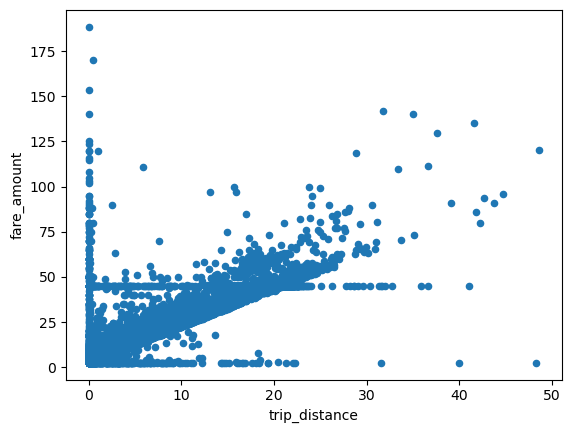

In [14]:
subset.plot(x="trip_distance", y="fare_amount", kind="scatter")

Or a little more involved to get a better formatted image:

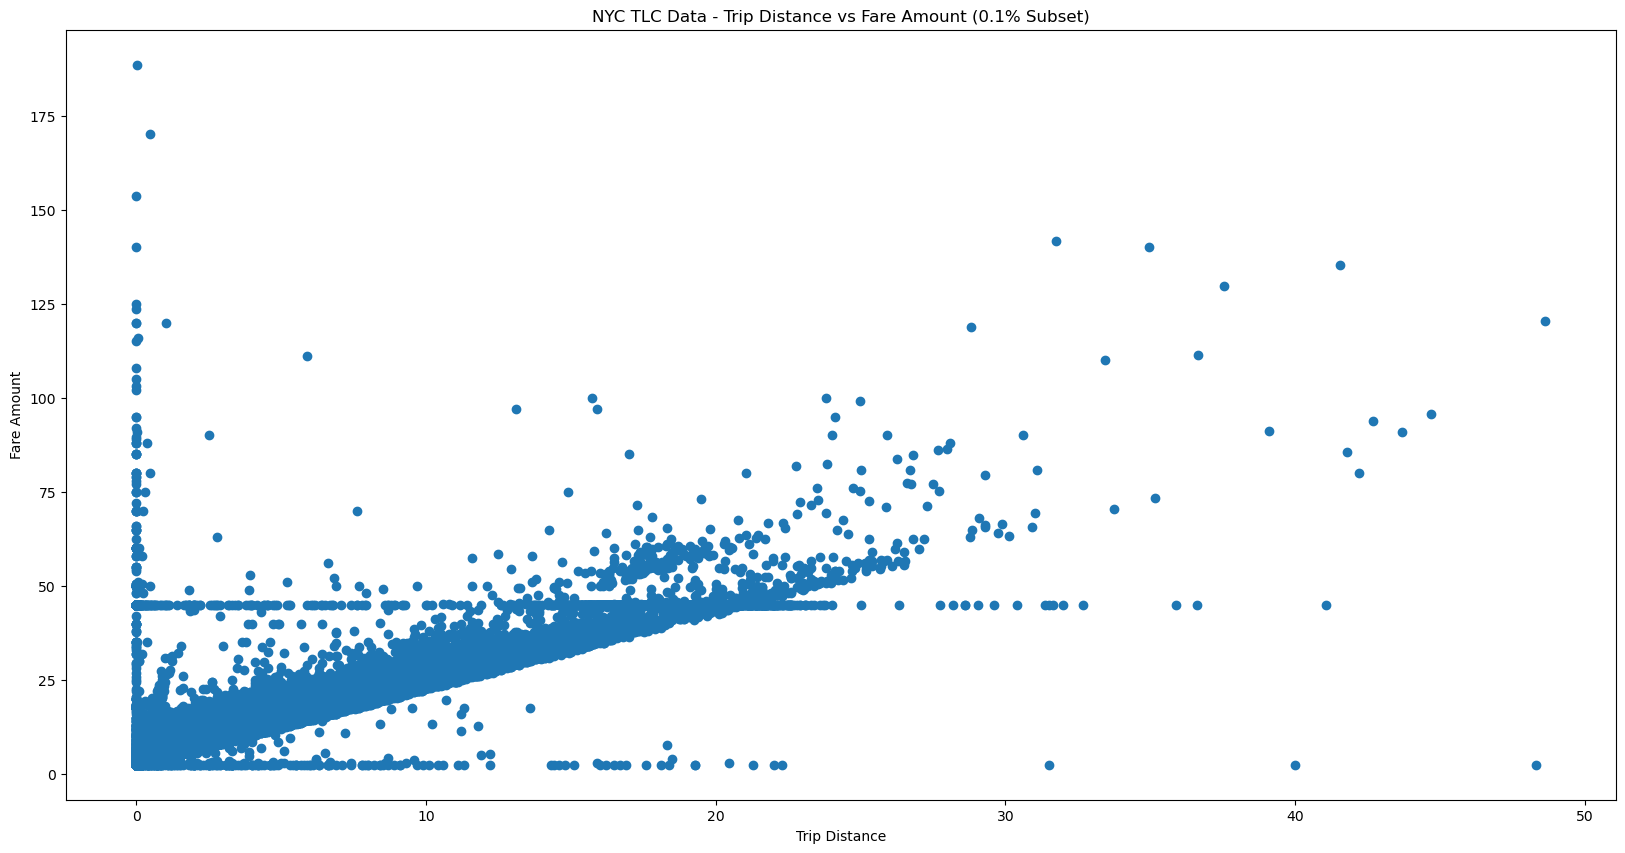

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[20, 10])
plt.scatter(
    subset["trip_distance"],
    subset["fare_amount"],
)
plt.title(f"NYC TLC Data - Trip Distance vs Fare Amount ({frac*100}% Subset)")
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.show()

The problem is pretty obvious: with this many data points it becomes impossible to distinguish individual data points when the density increases. There are literally hundreds of thousands of data points crammed into that bottom left corner. How many trips had a trip_distance of 20 miles and a fare_amount of 70? We simply can't tell from looking at this plot. 

And remember that this is only 0.1% of the dataset - there are 865 million more data points you would need to put on this graph to be complete!

You have two options here:
1. If you want to stick to using matplotlib or other standard plotting libraries, you'll have to reduce the number of data points even further. 
2. You can use DataShader to plot the entire dataset

### Plot Million-Point Datasets with DataShader
Datashader is an open-source Python library (part of the hvplot ecosystem) that was specifically developed for plotting million- and billion-point datasets. Rather than plotting a single point for each datapoint (which, as we have seen, quickly becomes unintelligble at this scale) Datashader instead uses a histogram method to create a color gradient that indicates the number of data points located on the same pixel. Generally speaking, darker pixels indicated less data points and lighter pixels indicate locations with higher density of data points.

For example, here's a datashader plot of all 300 million people in the US based on the 2010 census:

![image.png](attachment:cd1188e3-3c7b-4633-b44d-6d95faf3342d.png)

Fun fact: Datashader was built to work directly with Dask DataFrames.

#### Basic Datashader (Static)

Now that you've discovered Datashader, you're excited to try it out on your 868 million NYC TLC data points.

You import datashader, 

**NOTES**:
- datashader can't handle UInt8 and float16 it seems

## NEED TO CONVERT LOCATION DATA TO WEB MERCATOR!

### Undersampling Bokeh Plot

In [16]:
import holoviews as hv
import numpy as np
from holoviews import opts
from holoviews.element.tiles import StamenTonerBackgroundRetina

hv.extension("bokeh")

ModuleNotFoundError: No module named 'holoviews'

In [34]:
plot_width = int(750)
plot_height = int(plot_width // 1.2)
x_range, y_range = (-74.1, -73.7), (40.6, 40.9)
plot_options = hv.Options(width=plot_width, height=plot_height, xaxis=None, yaxis=None)

In [16]:
opts.defaults(
    opts.Points(width=plot_width, height=plot_height, size=5, color="blue"),
    opts.Overlay(width=plot_width, height=plot_height, xaxis=None, yaxis=None),
    opts.RGB(width=plot_width, height=plot_height),
)

In [36]:
samples_10k = ddf.sample(frac=0.00001).compute()
samples_1k = samples_10k.sample(n=1000)

In [130]:
len(samples_1k)

1000

In [170]:
tiles = StamenTonerBackgroundRetina().redim.range(x=x_range, y=y_range)
points = hv.Points(samples_1k, ["dropoff_longitude", "dropoff_latitude"])
tiles * points

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [dropoff_longitude,dropoff_latitude]   (vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount)

This lets us distinguish individual data points. But we are working with just over 0.0001% of the dataset. Not really a meaningful subset in any way.

### Oversampling: 10,000 data points (0.001%)

In [ ]:
samples_10k = ddf.sample(frac=0.00001).compute()

In [ ]:
len(samples)

9249

In [35]:
samples = ddf.sample(frac=0.00001).compute()
tiles = StamenTerrain().redim.range(x=x_range, y=y_range)
points = hv.Points(samples, ["dropoff_longitude", "dropoff_latitude"])
(tiles * points)

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [dropoff_longitude,dropoff_latitude]   (vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,payment_type,fare_amount,surcharge,tip_amount,tolls_amount,total_amount)

This is just .001 percent of the dataset. This means you are missing 99.999% of the datapoints (!)

Not acceptable.

### Plot all datapoints with Datashader

In [124]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9, Hot

Greys9_r = list(reversed(Greys9))[:-2]

In [125]:
%%time
cvs = ds.Canvas(
    plot_width=plot_width, plot_height=plot_height, x_range=x_range, y_range=y_range
)
agg = cvs.points(
    ddf, "dropoff_longitude", "dropoff_latitude", ds.count("passenger_count")
)
img = tf.shade(agg, cmap=["white", "darkblue"], how="linear")

CPU times: user 36.3 s, sys: 1.35 s, total: 37.6 s
Wall time: 3min 23s


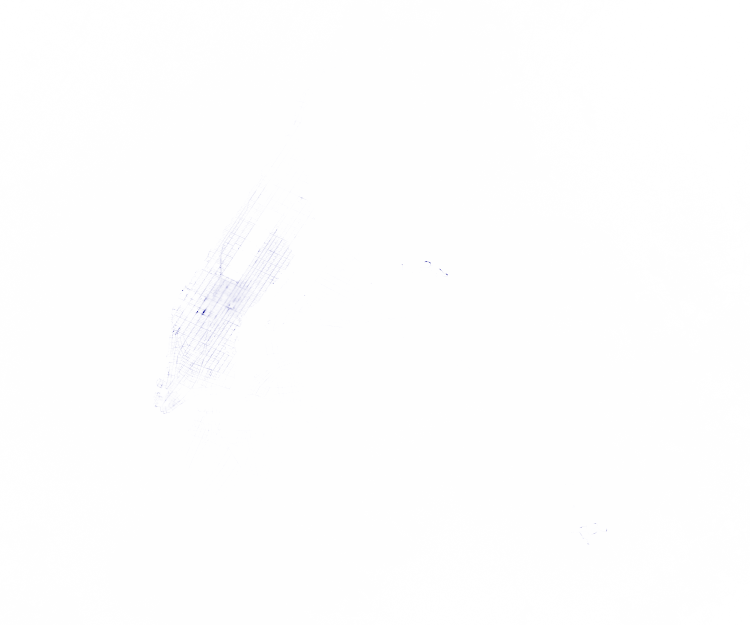

In [126]:
img

Non-linear scaling:

In [127]:
img2 = tf.shade(agg, cmap=Greys9_r, how="log")

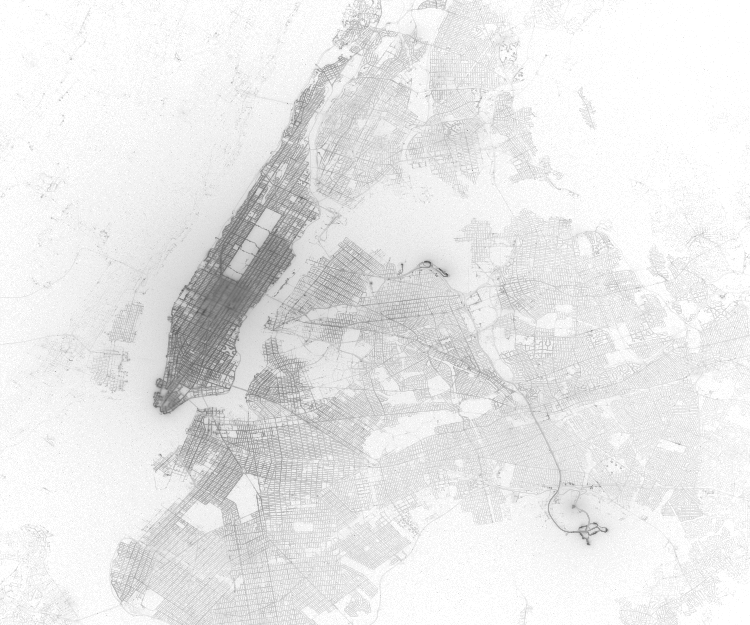

In [128]:
img2

**note to self**: Interesting, it looks like creating the `agg` object is what takes the biggest chunk of time here. After that, creating subsequent images is almost instant. I wonder if persisting `ddf` before creating the `agg` object would make this even faster.

CPU times: user 65.1 ms, sys: 10.6 ms, total: 75.8 ms
Wall time: 76.4 ms


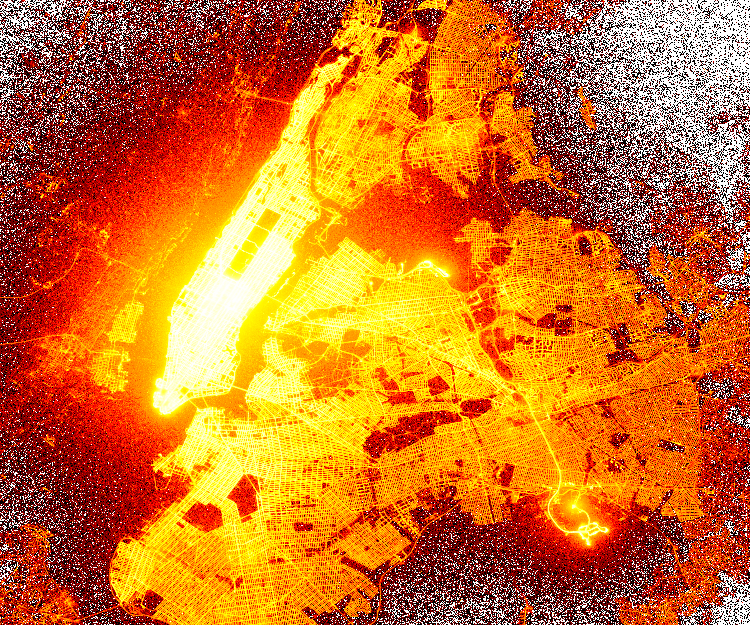

In [129]:
%%time
img3 = tf.shade(agg, cmap=Hot, how="eq_hist")
img3